In [81]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome


In [82]:
def get_robot(genome, params, neat_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(params["robot_size"])
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, params["robot_size"])

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, filename="../dynamic_env/env.json")
    img = env.render(mode='img')
    env.close()
    return robot, img

In [91]:
STEPS = 400
ROBOT_SIZE = 5
POP = 16

# directory = "results/" + ENV

params = {"robot_size": ROBOT_SIZE, "env": "dynamic", "steps": STEPS, "pop_size": POP}

morphology_coords = morph_substrate(ROBOT_SIZE)
CustomGenome.robot_func = lambda self, net, params: generate_robot(net, ROBOT_SIZE)
CustomGenome.substrate = morphology_coords
CustomGenome.robot_size = ROBOT_SIZE


neat_config = neat.config.Config(
    CustomGenome,
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/POET.cfg"
)

input_size = morphology_coords.dimensions*2 + 1 # two coordinates plus the bias
neat_config.genome_config.num_inputs = input_size
neat_config.genome_config.input_keys = [-1*i for i in range(1, input_size+1)]
neat_config.genome_config.num_outputs = 1
neat_config.genome_config.output_keys = [1]

with open(f"../poet/cp_gen_30.pkl", "rb") as file:
    poet_pop = pkl.load(file)



###################### Pair (0, 0) ########################

2058 0.4334647955021694


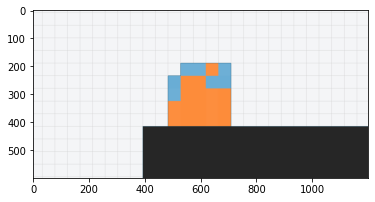

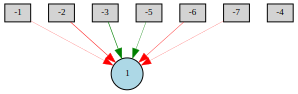

1981 2.3414607364757662


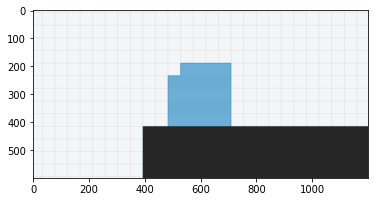

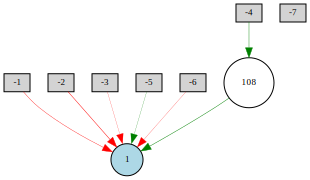



###################### Pair (2, 1) ########################

2069 0.35904187207104427


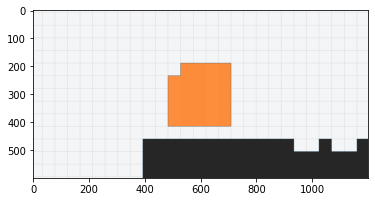

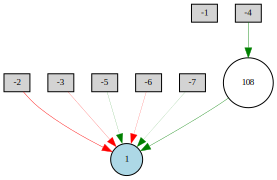

1539 2.7849697521432133


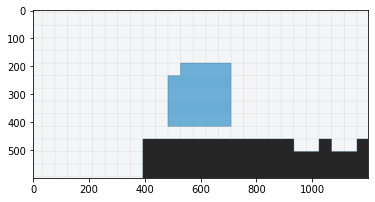

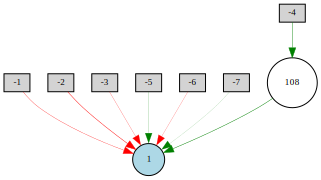



###################### Pair (2, 2) ########################

1990 0.06673876758409486


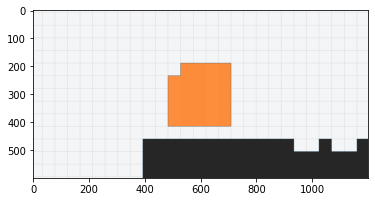

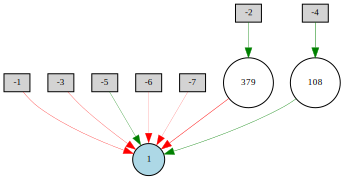

1539 2.7849697521432133


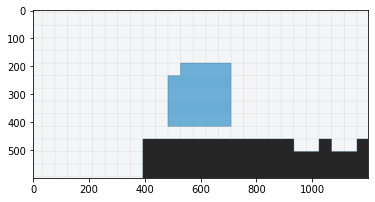

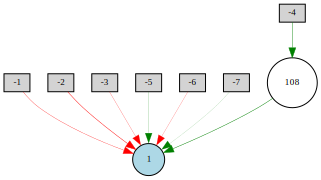



###################### Pair (31, 17) ########################

1990 0.04524947261260254


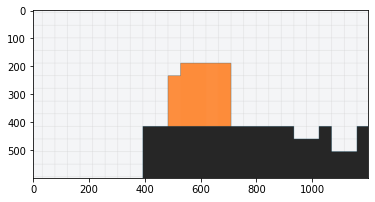

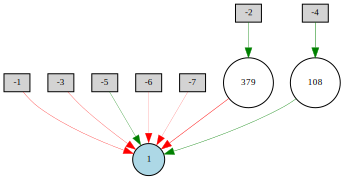

2041 3.5002842498498508


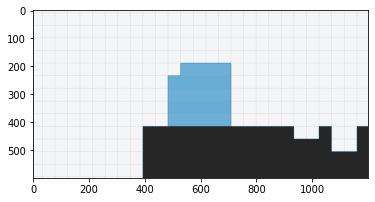

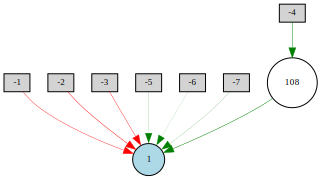



###################### Pair (11, 11) ########################

2087 2.3539560258142047


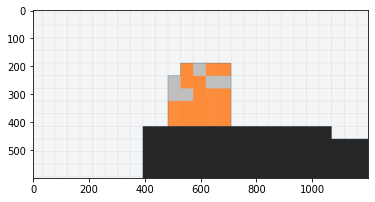

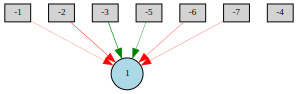

2041 3.254188472334198


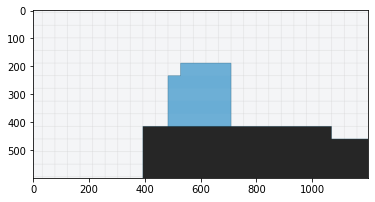

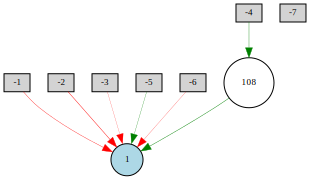

In [93]:
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair ({pop.id}, {env.id}) ########################\n")
    env.generate_json("env.json")
    for ag_id, ag in pop.pop.population.items():
        if ag.fitness is not None and ag.fitness > -10:
            r, img = get_robot(ag, params, neat_config)
            if img is not None:
                print(ag.key, ag.fitness)
                plt.imshow(img)
                plt.show()
                net = neat.nn.FeedForwardNetwork.create(ag, neat_config)
                display(draw_net(net))

In [97]:
env_dict = {}
ag_pop_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = ag
    env_dict[env.id] = env
    ag_pop_dict[pop.id] = pop



In [109]:
def show_exec(pop_id, ag_id, env_id, ag_pop_dict, ag_dict, env_dict):
    pop = ag_pop_dict[pop_id]
    env = env_dict[env_id]
    ag = ag_dict[ag_id]
    env.generate_json("env.json")
    reward, done = pop.single_genome_fit(ag, params["steps"], "dynamic", True, None)
    return reward, done

In [111]:
r, d = show_exec(11, 2041, 0, ag_pop_dict, ag_dict, env_dict)
print(r)

2.0316220453737386


In [115]:
print(env_dict[11].barrier_h)

1
